In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import MaxPooling2D, Dense, Flatten, TimeDistributed, Dropout, LSTM, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping
from IPython.display import Image
import joblib

In [12]:
# PATH_OLD="dataset"
PATH='dataset2.0'
# CLASS_LABLES1=listdir(PATH1)
CLASS_LABLES=listdir(PATH)
IMAGE_HEIGHT=32
IMAGE_WIDTH=32
SEQUENCE_LENGTH=20
SEED=42
EPOCHS=80
BATCH_SIZE=32

In [13]:
featureList=[]
labelList=[]
random.seed(SEED)
le=LabelEncoder()
# classCount=[0]*len(CLASS_LABLES)

In [14]:
for enum,i in enumerate(CLASS_LABLES):
    joinedPath=PATH+"/"+i
    newPath=listdir(joinedPath)
    for j in newPath:
        frameList=[]
        currentFrame=0
        cam=cv2.VideoCapture(joinedPath+"/"+j)
        frameCount=int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
        frameCut=max(1,int(frameCount/SEQUENCE_LENGTH))
        while True:
            ret,frame=cam.read()
            if ret:
                if currentFrame%frameCut==0 and len(frameList)!=SEQUENCE_LENGTH:
                    resizedFrame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
                    normalizedFrame=resizedFrame/255
                    frameList.append(normalizedFrame)
                currentFrame+=1
            else:
                break
        cam.release()
        if (len(frameList)==SEQUENCE_LENGTH): 
            featureList.append(np.asarray(frameList,np.float32))
            labelList.append(i)

In [15]:
featureList=np.asarray(featureList,dtype=np.float32)
labelList=le.fit_transform(np.array(labelList))
labelList=to_categorical(labelList)

In [16]:
featureList.shape

(13314, 20, 32, 32, 3)

In [17]:
featureTemp,featureTest,labelTemp,labelTest=train_test_split(
    featureList,
    labelList,
    shuffle=True,
    test_size=0.1,
    random_state=SEED
)

featureTrain,featureValidate,labelTrain,labelValidate=train_test_split(
    featureTemp,
    labelTemp,
    shuffle=True,
    test_size=0.35,
    random_state=SEED
)

In [18]:
len(featureTrain),len(featureValidate),len(featureTest)

(7788, 4194, 1332)

In [ ]:
model=Sequential(name="Movelytics")
model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3))))
model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu',padding='same')))
model.add(TimeDistributed(MaxPooling2D()))
# model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Conv2D(16,(3,3),activation='relu',padding='same')))
model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Conv2D(8,(3,3),activation='relu',padding='same')))
# model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
# model.add(TimeDistributed(Dropout(0.7)))

# model.add(TimeDistributed(Conv2D(8,(5,5),activation='relu',padding='same')))
# model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(8,(3,3),activation='relu',padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D()))
# model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256,activation='tanh',recurrent_activation='sigmoid',return_sequences=True))
model.add(LSTM(100,activation='tanh',recurrent_activation='sigmoid',return_sequences=False))

model.add(Dense(len(CLASS_LABLES),activation='softmax'))

In [ ]:
model.build(input_shape=(None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
model.summary()

Model: "Movelytics"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 32, 32, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 32, 32, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 16, 16, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 16, 16, 16)   4624      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 16, 16, 16)   6

In [ ]:
# plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

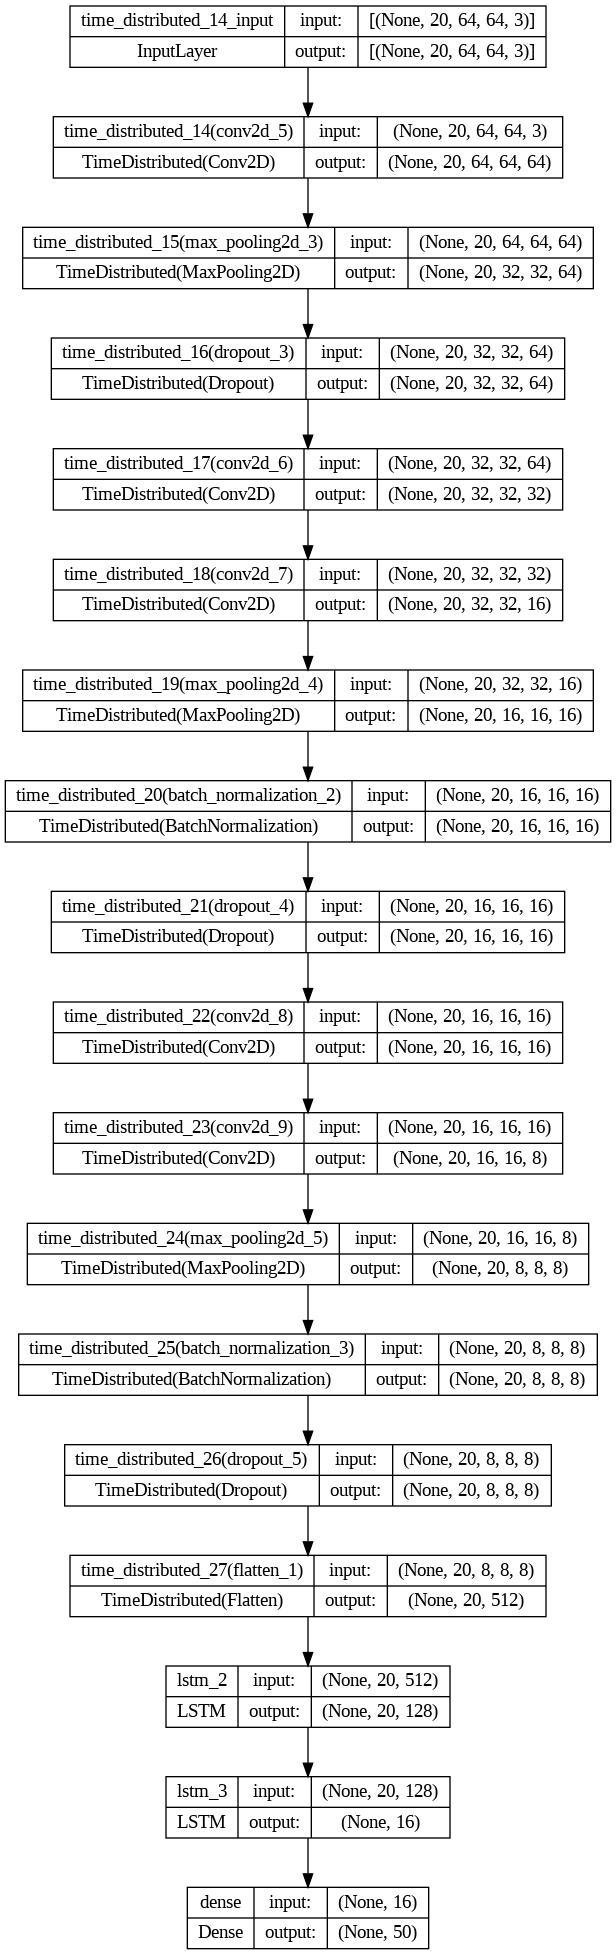

In [ ]:
Image(filename="model.png")

In [ ]:
# learningRateSchedule=tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.1,
#     decay_steps=5,
#     decay_rate=0.8
# )
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True,  
    mode='min',
    start_from_epoch=6
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
modelEval=model.fit(
    featureTrain,
    labelTrain,
    validation_data=(featureValidate,labelValidate),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
    # callbacks=[early_stopping]
)

Epoch 1/80
244/244 [==============================] - 107s 426ms/step - loss: 4.0548 - accuracy: 0.0985 - val_loss: 4.8171 - val_accuracy: 0.0277
Epoch 2/80
244/244 [==============================] - 103s 421ms/step - loss: 3.4749 - accuracy: 0.1724 - val_loss: 3.9570 - val_accuracy: 0.1226
Epoch 3/80
244/244 [==============================] - 107s 439ms/step - loss: 3.1469 - accuracy: 0.2365 - val_loss: 3.5525 - val_accuracy: 0.1662
Epoch 4/80
244/244 [==============================] - 106s 435ms/step - loss: 2.8206 - accuracy: 0.3025 - val_loss: 3.0261 - val_accuracy: 0.2635
Epoch 5/80
244/244 [==============================] - 95s 390ms/step - loss: 2.5264 - accuracy: 0.3662 - val_loss: 2.7718 - val_accuracy: 0.3131
Epoch 6/80
244/244 [==============================] - 94s 386ms/step - loss: 2.2999 - accuracy: 0.4194 - val_loss: 2.7932 - val_accuracy: 0.3091
Epoch 7/80
244/244 [==============================] - 95s 388ms/step - loss: 2.1022 - accuracy: 0.4578 - val_loss: 2.5519 - va

In [ ]:
model.evaluate(featureTest,labelTest)

42/42 [==============================] - 5s 108ms/step - loss: 1.8938 - accuracy: 0.6158


[1.8937878608703613, 0.6157894730567932]

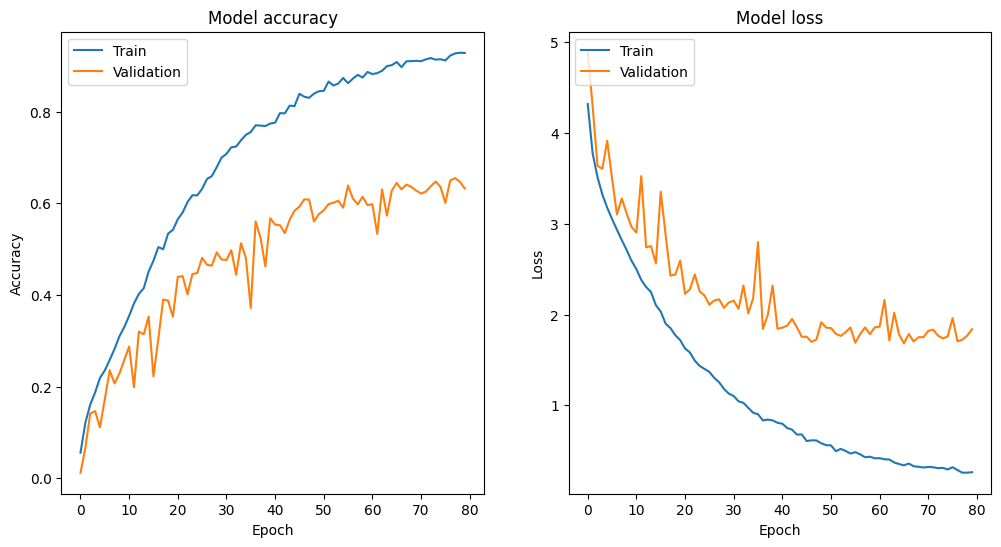

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(modelEval.history['accuracy'])
plt.plot(modelEval.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(modelEval.history['loss'])
plt.plot(modelEval.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# joblib.dump(model,"modelFinal.pkl")

['modelFinal.pkl']

In [19]:
modelep=joblib.load("movelytics84.75.pkl")

In [22]:
modelep.evaluate(featureTest,labelTest)

42/42 [==============================] - 2s 52ms/step - loss: 0.7200 - accuracy: 0.8476


[0.7200208306312561, 0.847597599029541]

In [ ]:
pred=modelep.predict(featureTest)

In [37]:
full=[]
for i in range(len(pred)):
    l=[]
    for j in range(101):
        if j==np.argmax(pred[i]):
            l.append(1)
        else:
            l.append(0)
    full.append(l)

In [24]:
from sklearn.metrics import classification_report

In [28]:
labelTest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
print(classification_report(labelTest,full))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.85      0.92      0.88        12
           2       1.00      0.94      0.97        17
           3       0.77      0.67      0.71        15
           4       1.00      1.00      1.00         7
           5       0.67      0.93      0.78        15
           6       0.87      0.81      0.84        16
           7       0.85      0.79      0.81        14
           8       0.95      1.00      0.97        18
           9       0.90      0.69      0.78        13
          10       1.00      1.00      1.00        17
          11       0.62      0.91      0.74        11
          12       1.00      0.79      0.88        14
          13       0.86      1.00      0.92         6
          14       0.94      0.94      0.94        17
          15       1.00      0.93      0.97        15
          16       0.67      1.00      0.80         8
          17       0.56    

In [8]:
import preProcessing as pp
a=pp.preprocessor('dataset2.0/ApplyingEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi')

In [9]:
CLASS_LABLES[np.argmax(modelep.predict(np.expand_dims(a,axis=0))[0])]

1/1 [==============================] - 1s 576ms/step


'ApplyingEyeMakeup'